In [1]:
from mppi import Utilities as U, Parsers as P

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

from scipy import integrate as I

hplanck = U.Planck_ev_ps*1e3 # Planck constant in ev*fs

# Analysis of the effect of the pulse width

We present the results of different computations performed with pumps of width 100 and 400 fs and for
different volume of the sampled k region.

In [2]:
path_nscf = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml'
path_nscf_ext = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml'

path100 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path100ext = 'RT_k200_kspan0.07/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path400 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-width_400/'

In [3]:
qedata = P.PwParser(path_nscf)
qedata_ext = P.PwParser(path_nscf_ext)

data100 = P.YamboParser.from_path(path100)
data100ext = P.YamboParser.from_path(path100ext)
data400 = P.YamboParser.from_path(path400)

field100 = data100['external_field']
carriers100 = data100['carriers']
spin100 = data100['spin_magnetization']

field100ext = data100ext['external_field']
carriers100ext = data100ext['carriers']
spin100ext = data100ext['spin_magnetization']

field400 = data400['external_field']
carriers400 = data400['carriers']
spin400 = data400['spin_magnetization']

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml


## Real time results

We compare the results of the degree of spin polarization in the various cases.

The time_shift is used to set the maximum of the fields at the same time

In [4]:
time_shift = 380

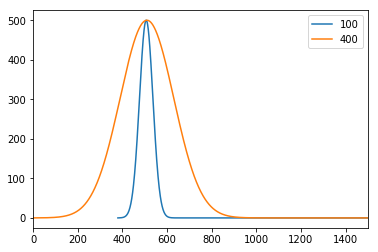

In [5]:
plt.plot(field100['time']+time_shift,field100['Intensity'],label=100)
plt.plot(field400['time'],field400['Intensity'],label=400)
plt.xlim(0,1500)
plt.legend()

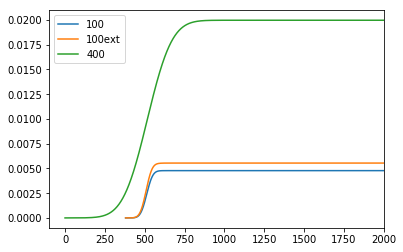

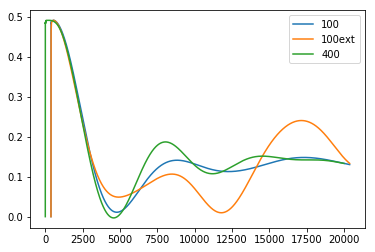

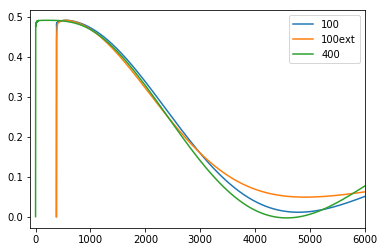

In [7]:
plt.plot(carriers100['time']+time_shift,carriers100['dne'],label=100)
plt.plot(carriers100ext['time']+time_shift,carriers100ext['dne']*0.07**3/0.05**3,label='100ext')
plt.plot(carriers400['time'],carriers400['dne'],label=400)
plt.xlim(-100,2000)
plt.legend()
plt.show()

plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin100ext['time']+time_shift,spin100ext['Mc_z'],label='100ext')
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.legend()
plt.show()

plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin100ext['time']+time_shift,spin100ext['Mc_z'],label='100ext')
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.xlim(-100,6000)
plt.legend()
plt.show()


The time profile of the depahsing phase is the same in all the cases. 

We justify this behavior by studying the shape of the JDOS for transitions among conduction
states in the k region activated by the pump.

### Energy spread of the pump

We evaluate the spectral width of the pumps by computing its FT.

In [8]:
dt100 = field100['time'][1]-field100['time'][0]
Ex100 = field100['Ex_Re']
N100 = Ex100.size

In [9]:
freq100 = np.fft.fftfreq(N100, d=dt100)
freq100plus = freq100[0:int(N100/2)]
Ex100FT = np.fft.fft(Ex100)
Int100FT = np.sqrt(Ex100FT.real**2+Ex100FT.imag**2)
Int100FT = Int100FT/Int100FT.max()
Int100FTplus = Int100FT[0:int(N100/2)]

In [10]:
dt400 = field400['time'][1]-field400['time'][0]
Ex400 = field400['Ex_Re']
N400 = Ex400.size

In [11]:
freq400 = np.fft.fftfreq(N400, d=dt400)
freq400plus = freq400[0:int(N400/2)]
Ex400FT = np.fft.fft(Ex400)
Int400FT = np.sqrt(Ex400FT.real**2+Ex400FT.imag**2)
Int400FT = Int400FT/Int400FT.max()
Int400FTplus = Int400FT[0:int(N400/2)]

(1.4, 1.6)

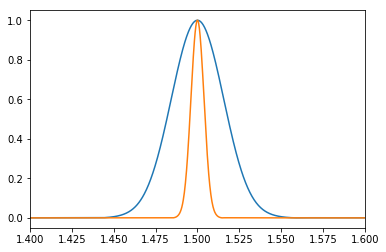

In [12]:
plt.plot(hplanck*freq100plus,Int100FTplus)
plt.plot(hplanck*freq400plus,Int400FTplus)
plt.xlim(1.4,1.6)

In [46]:
spread_thr = 5e-1

loc = np.where(Int100FTplus > spread_thr)
spread100 = 1e3*hplanck*(freq100plus[loc[0][-1]]-freq100plus[loc[0][0]])

loc = np.where(Int400FTplus > spread_thr)
spread400 = 1e3*hplanck*(freq400plus[loc[0][-1]]-freq400plus[loc[0][0]])
print('spread100 =',spread100)
print('spread400 =',spread400)

spread100 = 36.448935057286704
spread400 = 8.777429109431747


## JDOS in the optical active region

First of all we compute the transitions (both cv and cc') in the two K regions

In [47]:
trcv = qedata.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
trcvext = qedata_ext.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

trcc = 1e3*qedata.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
trccext = 1e3*qedata_ext.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

w = qedata.weights
wext = qedata_ext.weights

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV


These transitions produce the JDOS

In [48]:
jdoscv = U.Dos()
jdoscv.append_fromPwData(trcv,w,minVal=1,maxVal=2,eta=0.004,label='normal')
jdoscv.append_fromPwData(trcvext,wext,minVal=1,maxVal=2,eta=0.004,label='extended')

jdoscc = U.Dos()
jdoscc.append_fromPwData(trcc,w,minVal=-1,maxVal=3,eta=0.05,label='normal')
jdoscc.append_fromPwData(trccext,w,minVal=-1,maxVal=3,eta=0.05,label='extended')

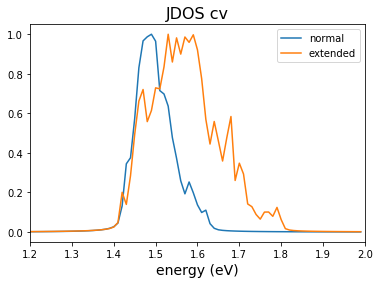

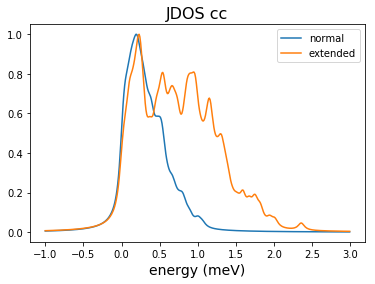

In [49]:
jdoscv.plot(plt,rescale=True)
plt.xlim(1.2,2)
plt.title('JDOS cv',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdoscc.plot(plt,rescale=True)
plt.title('JDOS cc',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()

Now we use the pump to select only the optical active transitions and comppute again the JDOS for optical
active transitions only.

In [50]:
def is_activated(t,epump,spread):
    emin = epump-1e-3*spread*0.5
    emax = epump+1e-3*spread*0.5
    t1 = np.mean(t[0:4])
    t2 = np.mean(t[4:])
    inside1 = emin <= t1 <= emax
    inside2 = emin <= t2 <= emax
    return np.any([inside1,inside2])

def get_kactivated(ttcv,epump,spread):
    kact = []
    for ind,t in enumerate(ttcv):
        if is_activated(t,epump,spread):
            kact.append(ind)
    return kact

def select_transitions(ttcv,ttcc,epump=1.5,spread=40):
    kact = get_kactivated(ttcv,epump,spread)
    ttcvact = []
    ttccact = []
    for k in kact:
        ttcvact.append(ttcv[k])
        ttccact.append(ttcc[k])
    return np.array(ttcvact).flatten(),np.array(ttccact).flatten()

In [51]:
trcv100, trcc100 = select_transitions(trcv,trcc,spread=spread100)
trcv100_ext, trcc100_ext = select_transitions(trcvext,trccext,spread=spread100)
trcv400, trcc400 = select_transitions(trcv,trcc,spread=spread400)

In [52]:
jdoscv_act = U.Dos()
jdoscv_act.append(trcv100,minVal=1,maxVal=2,eta=0.004,label=100)
jdoscv_act.append(trcv100_ext,minVal=1,maxVal=2,eta=0.004,label='100ext')
jdoscv_act.append(trcv400,minVal=1,maxVal=2,eta=0.004,label=400)

In [53]:
jdoscc_act = U.Dos()
jdoscc_act.append(trcc100,minVal=-1,maxVal=3,eta=0.05,label=100)
jdoscc_act.append(trcc100_ext,minVal=-1,maxVal=3,eta=0.05,label='100ext')
jdoscc_act.append(trcc400,minVal=-1,maxVal=3,eta=0.05,label=400)

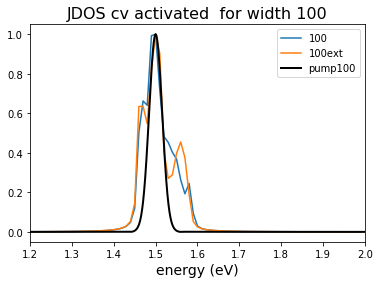

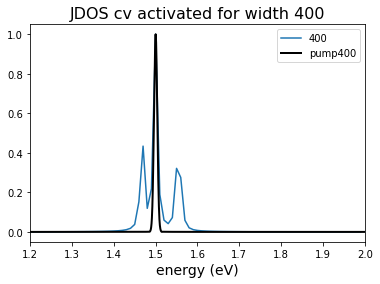

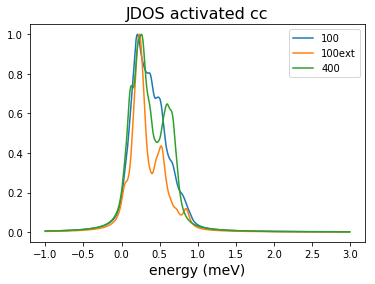

In [54]:
jdoscv_act.plot(plt,rescale=True,include=[0,1])
plt.plot(hplanck*freq100plus,Int100FTplus,c='black',linewidth=2,label='pump100')
plt.xlim(1.2,2)
plt.title('JDOS cv activated  for width 100',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdoscv_act.plot(plt,rescale=True,include=[2])
plt.plot(hplanck*freq400plus,Int400FTplus,c='black',linewidth=2,label='pump400')
plt.xlim(1.2,2)
plt.title('JDOS cv activated for width 400',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdoscc_act.plot(plt,rescale=True)
#plt.xlim(1.2,2)
plt.title('JDOS activated cc',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()
plt.show()

We compute the average of the cosine function using these JDOS cc'.

In [55]:
eng = jdoscc_act.dos[0][0]
values100 = jdoscc_act.dos[0][1]
values100_ext = jdoscc_act.dos[1][1]
values400 = jdoscc_act.dos[2][1]

norm100 = I.simps(y=values100,x=eng)
norm100_ext = I.simps(y=values100_ext,x=eng)
norm400 = I.simps(y=values400,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus
tvals = np.linspace(0,20,200)

res100 = []
res100_ext = []
res400 = []
for t in tvals:
    integrand100 = values100*np.cos(omegas*t)
    res100.append(1/norm100*I.simps(y=integrand100,x=eng))
    integrand100_ext = values100_ext*np.cos(omegas*t)
    res100_ext.append(1/norm100_ext*I.simps(y=integrand100_ext,x=eng))
    integrand400 = values400*np.cos(omegas*t)
    res400.append(1/norm400*I.simps(y=integrand400,x=eng))
res100 = np.array(res100)
res100_ext= np.array(res100_ext)
res400 = np.array(res400)

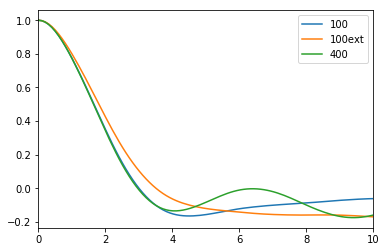

In [56]:
plt.plot(tvals,res100,label=100)
plt.plot(tvals,res100_ext,label='100ext')
plt.plot(tvals,res400,label=400)
plt.xlim(0,10)
plt.legend()

## Suggestion for simulations at various pump energy

Looking at the JDOS cc we can estimate the dephasing rate when the pump energy in changed (using the 
same spread100 value). For instance

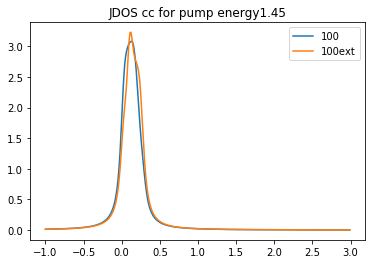

In [90]:
ep = 1.45
trcv100, trcc100 = select_transitions(trcv,trcc,spread=spread100,epump=ep)
trcv100_ext, trcc100_ext = select_transitions(trcvext,trccext,spread=spread100,epump=ep)

jdoscc_act = U.Dos()
jdoscc_act.append(trcc100,minVal=-1,maxVal=3,eta=0.05,label=100)
jdoscc_act.append(trcc100_ext,minVal=-1,maxVal=3,eta=0.05,label='100ext')

jdoscc_act.plot(plt)
plt.title('JDOS cc for pump energy'+str(ep))
plt.legend()

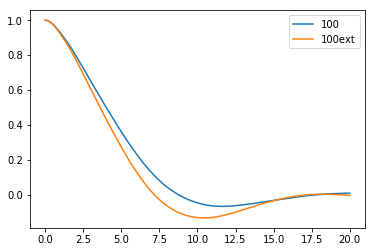

In [94]:
eng = jdoscc_act.dos[0][0]
values100 = jdoscc_act.dos[0][1]
values100_ext = jdoscc_act.dos[1][1]

norm100 = I.simps(y=values100,x=eng)
norm100_ext = I.simps(y=values100_ext,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus
tvals = np.linspace(0,20,200)

res100 = []
res100_ext = []
for t in tvals:
    integrand100 = values100*np.cos(omegas*t)
    res100.append(1/norm100*I.simps(y=integrand100,x=eng))
    integrand100_ext = values100_ext*np.cos(omegas*t)
    res100_ext.append(1/norm100_ext*I.simps(y=integrand100_ext,x=eng))
res100 = np.array(res100)
res100_ext= np.array(res100_ext)

plt.plot(tvals,res100,label=100)
plt.plot(tvals,res100_ext,label='100ext')
plt.legend()

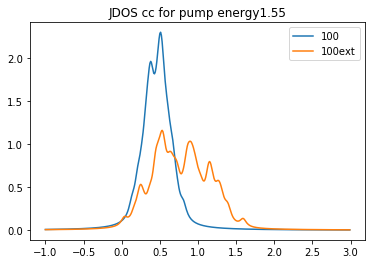

In [95]:
ep = 1.55
trcv100, trcc100 = select_transitions(trcv,trcc,spread=spread100,epump=ep)
trcv100_ext, trcc100_ext = select_transitions(trcvext,trccext,spread=spread100,epump=ep)

jdoscc_act = U.Dos()
jdoscc_act.append(trcc100,minVal=-1,maxVal=3,eta=0.05,label=100)
jdoscc_act.append(trcc100_ext,minVal=-1,maxVal=3,eta=0.05,label='100ext')

jdoscc_act.plot(plt)
plt.title('JDOS cc for pump energy'+str(ep))
plt.legend()

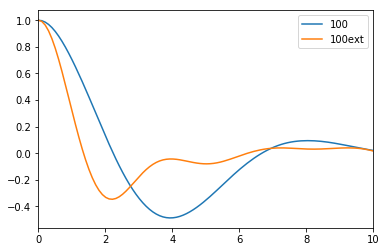

In [97]:
eng = jdoscc_act.dos[0][0]
values100 = jdoscc_act.dos[0][1]
values100_ext = jdoscc_act.dos[1][1]

norm100 = I.simps(y=values100,x=eng)
norm100_ext = I.simps(y=values100_ext,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus
tvals = np.linspace(0,20,200)

res100 = []
res100_ext = []
for t in tvals:
    integrand100 = values100*np.cos(omegas*t)
    res100.append(1/norm100*I.simps(y=integrand100,x=eng))
    integrand100_ext = values100_ext*np.cos(omegas*t)
    res100_ext.append(1/norm100_ext*I.simps(y=integrand100_ext,x=eng))
res100 = np.array(res100)
res100_ext= np.array(res100_ext)

plt.plot(tvals,res100,label=100)
plt.plot(tvals,res100_ext,label='100ext')
plt.xlim(0,10)
plt.legend()

This shows that the 'normal' sampling region is not adequate for the 1.55 pump energy.

In [39]:
###################################################################################################################
###################################################################################################################

In [2]:
path_nscf = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml'
path_nscf_ext = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml'
path_nscf_red = 'NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma_kspan0.03.save/data-file-schema.xml'

path100 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path400 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-width_400/'
path400_v1 = 'RT_k200_v1/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-width_400/'
path400red = 'RT_k100_kspan0.03/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-width_400/'

In [3]:
qedata = P.PwParser(path_nscf)
qedata_ext = P.PwParser(path_nscf_ext)

data100 = P.YamboParser.from_path(path100)
data100ext = P.YamboParser.from_path(path100ext)
data400 = P.YamboParser.from_path(path400)


field100 = data100['external_field']
carriers100 = data100['carriers']
spin100 = data100['spin_magnetization']

field400 = data400['external_field']
carriers400 = data400['carriers']
spin400 = data400['spin_magnetization']

field400v1 = data400v1['external_field']
carriers400v1 = data400v1['carriers']
spin400v1 = data400v1['spin_magnetization']

field400red = data400red['external_field']
carriers400red = data400red['carriers']
spin400red = data400red['spin_magnetization']

field100v1 = data100v1['external_field']
carriers100v1 = data100v1['carriers']
spin100v1 = data100v1['spin_magnetization']

field100ext = data100ext['external_field']
carriers100ext = data100ext['carriers']
spin100ext = data100ext['spin_magnetization']

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma_kspan0.03.save/data-file-schema.xml


## Real time results

We compare the results of the degree of spin polarization in the two cases.

We start looking at the profile of the field intensity. The time_shift is used to set the maximum of the fields
at the same time

In [4]:
time_shift = 380

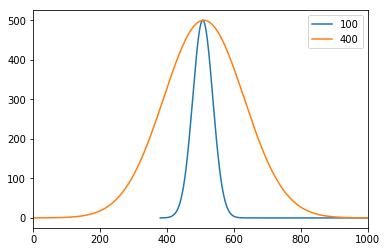

In [5]:
plt.plot(field100['time']+time_shift,field100['Intensity'],label=100)
plt.plot(field400['time'],field400['Intensity'],label=400)
#plt.plot(field400red['time'],field400red['Intensity'],label='400red')
plt.xlim(0,1000)
plt.legend()

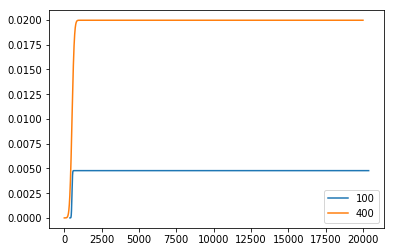

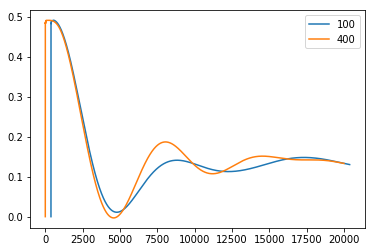

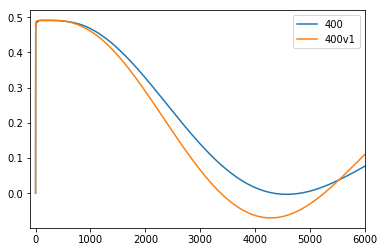

In [6]:
plt.plot(carriers100['time']+time_shift,carriers100['dne'],label=100)
plt.plot(carriers400['time'],carriers400['dne'],label=400)
#plt.plot(carriers400red['time'],carriers400red['dne'],label='400red')
plt.legend()
plt.show()

plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
#plt.plot(spin400red['time'],spin400red['Mc_z'],label='400red')
plt.legend()
plt.show()

#plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.plot(spin400v1['time'],spin400v1['Mc_z'],label='400v1')
#plt.plot(spin400red['time'],spin400red['Mc_z'],label='400red')
plt.xlim(-100,6000)
plt.legend()

Some comments:

* The number of carriers is higher for w=400 (where less kpoints should contribute), but with higher field.
  There can be a convergence problem? Check with the result for w=400 in the reduced kregion

* The signal dephasing time is equal in the two cases. This means that the maximum frequencies that contribute
 to the two curves are almost the same
 
* The curve for width=400 has higher oscillations for long time, this could mean that less k points are involved
  by this pump

To confirm these behavior we also consider two further results, related to the width=100 pump, but
performed with a grid made of different k points and in a extented sampling region.

In [7]:
path100v1 = 'RT_k200_v1/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path100ext = 'RT_k200_kspan0.07/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'

In [8]:
data100v1 = P.YamboParser.from_path(path100v1)
data100ext = P.YamboParser.from_path(path100ext)

field100v1 = data100v1['external_field']
carriers100v1 = data100v1['carriers']
spin100v1 = data100v1['spin_magnetization']

field100ext = data100ext['external_field']
carriers100ext = data100ext['carriers']
spin100ext = data100ext['spin_magnetization']

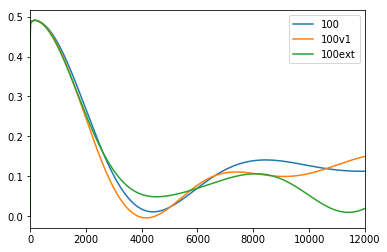

In [9]:
plt.plot(spin100['time'],spin100['Mc_z'],label=100)
plt.plot(spin100v1['time'],spin100v1['Mc_z'],label='100v1')
plt.plot(spin100ext['time'],spin100ext['Mc_z'],label='100ext')
plt.xlim(0,12000)
plt.legend()
plt.show()

We observe that the time profile of the dephasing of the signal is the same

Lastly we compare the results using 500 point with the nosym option

In [10]:
path500_100 = 'RT_k500-keepGrid/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-width_100/'
path500_400 = 'RT_k500-keepGrid/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-width_400/'

data500_100 = P.YamboParser.from_path(path500_100)
data500_400 = P.YamboParser.from_path(path500_400)

field500_100 = data500_100['external_field']
carriers500_100 = data500_100['carriers']
spin500_100 = data500_100['spin_magnetization']

field500_400 = data500_400['external_field']
carriers500_400 = data500_400['carriers']
spin500_400 = data500_400['spin_magnetization']

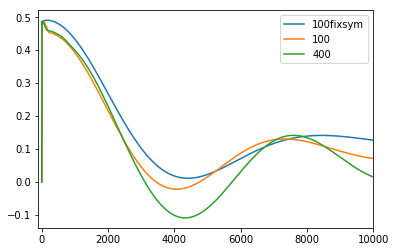

In [11]:
plt.plot(spin100['time'],spin100['Mc_z'],label='100fixsym')
plt.plot(spin500_100['time'],spin500_100['Mc_z'],label=100)
plt.plot(spin500_400['time'],spin500_400['Mc_z'],label=400)
plt.xlim(-100,10000)
plt.legend()
plt.show()

In [12]:
print(spin500_400['time'][np.where(spin500_400['Mc_z'] == min(spin500_400['Mc_z']))[0][0]])
print(spin500_100['time'][np.where(spin500_100['Mc_z'] == min(spin500_100['Mc_z']))[0][0]]+time_shift)
print(spin100['time'][np.where(spin100['Mc_z'] == min(spin100['Mc_z'][2:]))[0][0]]+time_shift)

4325.0
4446.0
4787.84


## Analysis JDOS for cc' transitions

We build the JDOS for the cc' transitions im the various cases.

First of all we compute the JDOS associated to standard and the extended k sampling region

In [10]:
trcv = qedata.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
trcvext = qedata_ext.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
trcvred = qedata_red.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

trcc = 1e3*qedata.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
trccext = 1e3*qedata_ext.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
trccred = 1e3*qedata_red.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

w = qedata.weights
wext = qedata_ext.weights
wred = qedata_red.weights

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV
Apply a scissor of 0.5456147497318283 eV


In [11]:
jdos_cv = U.Dos()
jdos_cv.append_fromPwData(trcv,w,minVal=1,maxVal=2,eta=0.004,label='normal')
jdos_cv.append_fromPwData(trcvext,wext,minVal=1,maxVal=2,eta=0.004,label='extended')
jdos_cv.append_fromPwData(trcvred,wred,minVal=1,maxVal=2,eta=0.004,label='reduced')

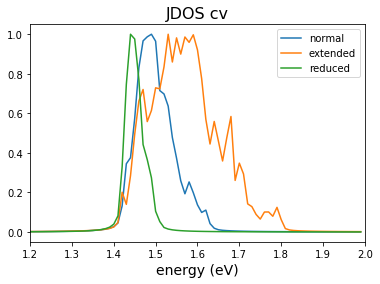

In [12]:
jdos_cv.plot(plt,rescale=True)
plt.xlim(1.2,2)
plt.title('JDOS cv',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()

From these transitions we can compute the JDOS

In [13]:
jdos = U.Dos()
jdos.append_fromPwData(trcc,w,minVal=-2,maxVal=3,eta=0.05,label='tr')
jdos.append_fromPwData(trccext,wext,minVal=-2,maxVal=3,eta=0.05,label='trext')
jdos.append_fromPwData(trccred,wred,minVal=-2,maxVal=3,eta=0.05,label='trred')

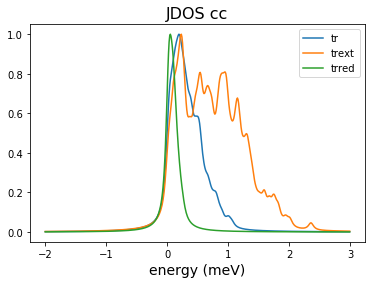

In [14]:
jdos.plot(plt,rescale=True)
plt.title('JDOS cc',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()

The JDOS are different and if we computed the average of the cosine function we obtain:

In [15]:
eng = jdos.dos[0][0]
values = jdos.dos[0][1]
values_ext = jdos.dos[1][1]

In [16]:
norm = I.simps(y=values,x=eng)
norm_ext = I.simps(y=values_ext,x=eng)

In [17]:
nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

In [18]:
tvals = np.linspace(0,20,200)

In [19]:
res = []
res_ext = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
    integrand_ext = values_ext*np.cos(omegas*t)
    res_ext.append(1/norm*I.simps(y=integrand_ext,x=eng))
res = np.array(res)
res_ext= np.array(res_ext)

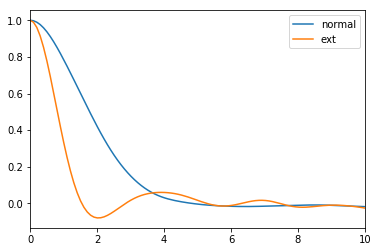

In [20]:
plt.plot(tvals,res,label='normal')
plt.plot(tvals,res_ext,label='ext')
plt.xlim(0,10)
plt.legend()

According to this analysis the signal computed in the wider samplign region should dephase faster.
However this analysis does not take into account the width of the field, so that only the transitions
inside the width of the field can be activated by the pump.

### Inclusion of the effects of the width of the pump

We evaluate the spectral width of the pump of temporal width of 100 fs by computing its FT

In [21]:
dt100 = field100['time'][1]-field100['time'][0]
Ex100 = field100['Ex_Re']
N100 = Ex100.size

In [22]:
freq100 = np.fft.fftfreq(N100, d=dt100)
freq100plus = freq100[0:int(N100/2)]
Ex100FT = np.fft.fft(Ex100)
Int100FT = np.sqrt(Ex100FT.real**2+Ex100FT.imag**2)
Int100FT = Int100FT/Int100FT.max()
Int100FTplus = Int100FT[0:int(N100/2)]

In [23]:
dt400 = field400['time'][1]-field400['time'][0]
Ex400 = field400['Ex_Re']
N400 = Ex400.size

In [24]:
freq400 = np.fft.fftfreq(N400, d=dt400)
freq400plus = freq400[0:int(N400/2)]
Ex400FT = np.fft.fft(Ex400)
Int400FT = np.sqrt(Ex400FT.real**2+Ex400FT.imag**2)
Int400FT = Int400FT/Int400FT.max()
Int400FTplus = Int400FT[0:int(N400/2)]

(1.4, 1.6)

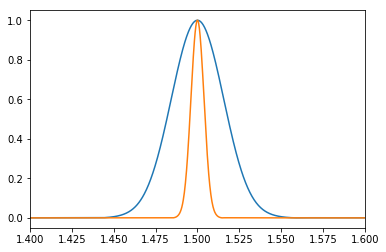

In [25]:
plt.plot(hplanck*freq100plus,Int100FTplus)
plt.plot(hplanck*freq400plus,Int400FTplus)
plt.xlim(1.4,1.6)

In [63]:
spread_thr = 3e-1

loc = np.where(Int100FTplus > spread_thr)
spread100 = 1e3*hplanck*(freq100plus[loc[0][-1]]-freq100plus[loc[0][0]])

loc = np.where(Int400FTplus > spread_thr)
spread400 = 1e3*hplanck*(freq400plus[loc[0][-1]]-freq400plus[loc[0][0]])
print('spread100 =',spread100)
print('spread400 =',spread400)

spread100 = 48.02683207548338
spread400 = 11.774600024847347


The width of the pump has to be taken into account in the JDOS cv that select the 
transitions that are activated by the pump. Only these transitions contribute to the 
JDOS cc'.

In [27]:
jdos_cv = U.Dos()
jdos_cv.append_fromPwData(trcv,w,minVal=1,maxVal=2,eta=0.004,label='normal')
jdos_cv.append_fromPwData(trcvext,wext,minVal=1,maxVal=2,eta=0.004,label='extended')
jdos_cv.append_fromPwData(trcvred,wred,minVal=1,maxVal=2,eta=0.004,label='reduced')

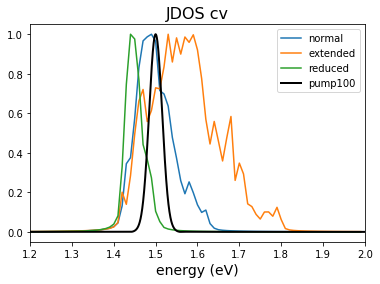

In [28]:
jdos_cv.plot(plt,rescale=True)
plt.plot(hplanck*freq100plus,Int100FTplus,c='black',linewidth=2,label='pump100')
plt.xlim(1.2,2)
plt.title('JDOS cv',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()

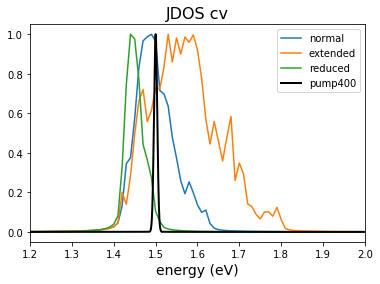

In [29]:
jdos_cv.plot(plt,rescale=True)
plt.plot(hplanck*freq400plus,Int400FTplus,c='black',linewidth=2,label='pump400')
plt.xlim(1.2,2)
plt.title('JDOS cv',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()

We have to select only the transitions inside the pulse width

In [30]:
trcv[175]

array([1.49461789, 1.49479397, 1.49418776, 1.49436383, 1.46671659,
       1.46689267, 1.46667402, 1.4668501 ])

In [31]:
def is_activated(t,epump,spread):
    emin = epump-1e-3*spread*0.5
    emax = epump+1e-3*spread*0.5
    t1 = np.mean(t[0:4])
    t2 = np.mean(t[4:])
    inside1 = emin <= t1 <= emax
    inside2 = emin <= t2 <= emax
    return np.any([inside1,inside2])

def get_kactivated(ttcv,epump,spread):
    kact = []
    for ind,t in enumerate(ttcv):
        if is_activated(t,epump,spread):
            kact.append(ind)
    return kact

def select_transitions(ttcv,ttcc,epump=1.5,spread=40):
    kact = get_kactivated(ttcv,epump,spread)
    ttcvact = []
    ttccact = []
    for k in kact:
        ttcvact.append(ttcv[k])
        ttccact.append(ttcc[k])
    return np.array(ttcvact).flatten(),np.array(ttccact).flatten()

In [32]:
np.any([True,False])

True

In [64]:
tractcv, tractcc = select_transitions(trcv,trcc,spread=spread100)
tractcv_ext, tractcc_ext = select_transitions(trcvext,trccext,spread=spread100)

In [65]:
trcc.size

200

In [66]:
tractcc.size

152

In [67]:
tractcc_ext.size

63

In [68]:
jdoscvact = U.Dos()
jdoscvact.append(tractcv,minVal=1,maxVal=2,eta=0.004,label='normal')
jdoscvact.append(tractcv_ext,minVal=1,maxVal=2,eta=0.004,label='extended')

jdosccact = U.Dos()
jdosccact.append(tractcc,minVal=-2,maxVal=2,eta=0.05,label='normal')
jdosccact.append(tractcc_ext,minVal=-2,maxVal=2,eta=0.05,label='extended')

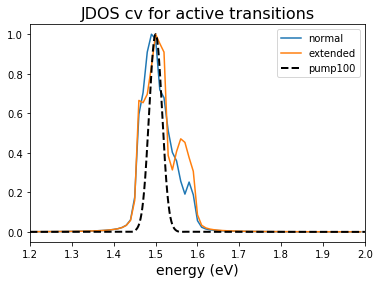

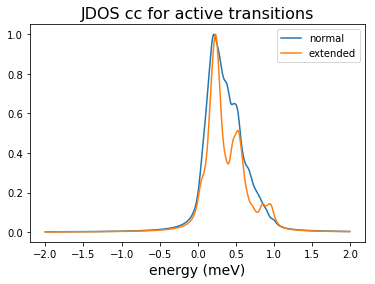

In [69]:
jdoscvact.plot(plt,rescale=True)
plt.plot(hplanck*freq100plus,Int100FTplus,c='black',linewidth=2,linestyle='--',label='pump100')
plt.xlim(1.2,2)
plt.title('JDOS cv for active transitions',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdosccact.plot(plt,rescale=True)
#plt.xlim(1.2,2)
plt.title('JDOS cc for active transitions',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()

This plot shows how the field selects the transitions. The average of the cosine with this distributions is

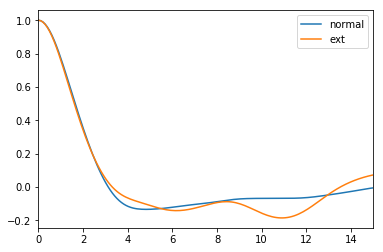

In [70]:
eng = jdosccact.dos[0][0]
values = jdosccact.dos[0][1]
values_ext = jdosccact.dos[1][1]

norm = I.simps(y=values,x=eng)
norm_ext = I.simps(y=values_ext,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

tvals = np.linspace(0,20,200)

res = []
res_ext = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
    integrand_ext = values_ext*np.cos(omegas*t)
    res_ext.append(1/norm*I.simps(y=integrand_ext,x=eng))
res = np.array(res)
res_ext= np.array(res_ext)

plt.plot(tvals,res,label='normal')
plt.plot(tvals,res_ext,label='ext')
plt.xlim(0,15)
plt.legend()

Thanks to the selection performed by the pump the time profile of the dephasing is (almost) equal, 
in agreement with the result of the rt computation

### Analysis of the selection due to the field with w=400

In [71]:
tractcv, tractcc = select_transitions(trcv,trcc,spread=spread400)
#tractcv_red, tractcc_red = select_transitions(trcvred,trccred,spread=spread400)

In [72]:
trcc.size

200

In [73]:
tractcc.size

46

In [74]:
#tractcc_red.size

In [75]:
jdoscvact = U.Dos()
jdoscvact.append(tractcv,minVal=1,maxVal=2,eta=0.004,label='normal')

jdosccact = U.Dos()
jdosccact.append(tractcc,minVal=-2,maxVal=2,eta=0.05,label='normal')

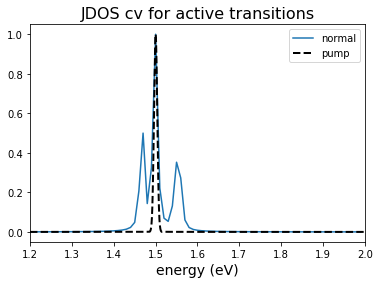

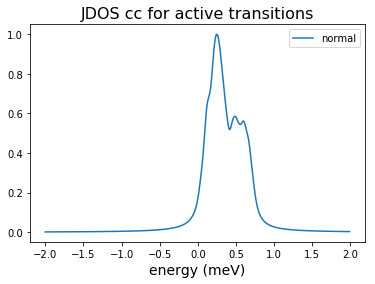

In [78]:
jdoscvact.plot(plt,rescale=True)
plt.plot(hplanck*freq400plus,Int400FTplus,c='black',linewidth=2,linestyle='--',label='pump')
plt.xlim(1.2,2)
plt.title('JDOS cv for active transitions',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdosccact.plot(plt,rescale=True)
#plt.xlim(1.2,2)
plt.title('JDOS cc for active transitions',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()

Using this criterion it seems that no transition can be activated....

There is some error in the way in which we select the active transitions...

## Analysis for pump at 1.42 eV

In [48]:
path100 = 'RT_k100_kspan0.03/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_10000-width_100/'
path400 = 'RT_k100_kspan0.03/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_10000-width_400/'

data100 = P.YamboParser.from_path(path100)
data400 = P.YamboParser.from_path(path400)

In [49]:
field100 = data100['external_field']
carriers100 = data100['carriers']
spin100 = data100['spin_magnetization']

field400 = data400['external_field']
carriers400 = data400['carriers']
spin400 = data400['spin_magnetization']

In [50]:
time_shift = 380

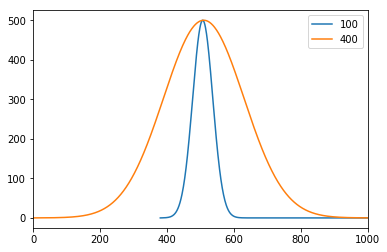

In [51]:
plt.plot(field100['time']+time_shift,field100['Intensity'],label=100)
plt.plot(field400['time'],field400['Intensity'],label=400)
plt.xlim(0,1000)
plt.legend()

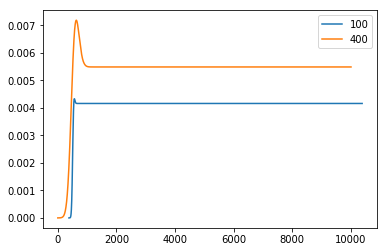

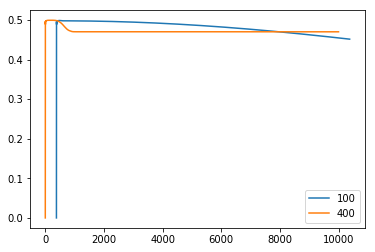

In [52]:
plt.plot(carriers100['time']+time_shift,carriers100['dne'],label=100)
plt.plot(carriers400['time'],carriers400['dne'],label=400)
plt.legend()
plt.show()

plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.legend()
plt.show()

Puo essere che la forma della JDOS cc' si ottiene fissato un deps_cv dal contributo dei deps_cc' di tutti i 
k che con quel deps_cv (che poi è quello che succede nella realtà se considero i k attivati da una certa pump)